In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')

In [4]:
train_matfile = maybe_download('train_32x32.mat')
test_matfile = maybe_download('test_32x32.mat')
extra_matfile = maybe_download('extra_32x32.mat')

In [1]:
import scipy.io
train_data = scipy.io.loadmat('train_32x32.mat', variable_names='X').get('X')
train_labels = scipy.io.loadmat('train_32x32.mat', variable_names='y').get('y')
test_data = scipy.io.loadmat('test_32x32.mat', variable_names='X').get('X')
test_labels = scipy.io.loadmat('test_32x32.mat', variable_names='y').get('y')
extra_data = scipy.io.loadmat('extra_32x32.mat', variable_names='X').get('X')
extra_labels = scipy.io.loadmat('extra_32x32.mat', variable_names='y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

((32, 32, 3, 73257), (73257, 1))
((32, 32, 3, 26032), (26032, 1))
((32, 32, 3, 531131), (531131, 1))


In [2]:
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

In [6]:
# Build Validation Dataset and Labels Based on the Methods in This Paper:
# [https://arxiv.org/pdf/1204.3968.pdf]

import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,0] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,0] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,0] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,0] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_data = np.concatenate((extra_data[:,:,:,valid_index2], train_data[:,:,:,valid_index]), axis=3).transpose((3,0,1,2))
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)[:,0]
train_data_t = np.concatenate((extra_data[:,:,:,train_index2], train_data[:,:,:,train_index]), axis=3).transpose((3,0,1,2))
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)[:,0]
test_data = test_data.transpose((3,0,1,2))
test_labels = test_labels[:,0]

print(train_data_t.shape, train_labels_t.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(598388, 32, 32, 3) (598388,)
(26032, 32, 32, 3) (26032,)
(6000, 32, 32, 3) (6000,)


In [7]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # Use the Conversion Method in This Paper:
    # [http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf]
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(train_data_t)[:,:,:,0]
test_data_c = im2gray(test_data)[:,:,:,0]
valid_data_c = im2gray(valid_data)[:,:,:,0]

print(train_data_c.shape, train_labels_t.shape)
print(test_data_c.shape, test_labels.shape)
print(valid_data_c.shape, valid_labels.shape)

(598388, 32, 32) (598388,)
(26032, 32, 32) (26032,)
(6000, 32, 32) (6000,)


In [8]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""
    
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN

train_data_GCN = GCN(train_data_c)
test_data_GCN = GCN(test_data_c)
valid_data_GCN = GCN(valid_data_c)

print(train_data_GCN.shape, train_labels_t.shape)
print(test_data_GCN.shape, test_labels.shape)
print(valid_data_GCN.shape, valid_labels.shape)

(598388, 32, 32) (598388,)
(26032, 32, 32) (26032,)
(6000, 32, 32) (6000,)


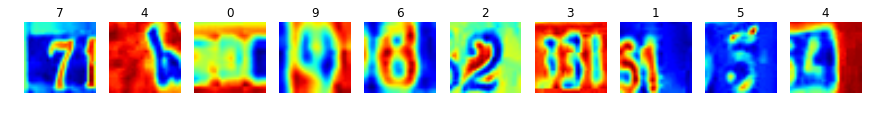

In [9]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels_t.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels_t[j], loc='center')
    ax[i].imshow(train_data_GCN[j,:,:])

In [14]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    #'train_dataset': train_data_GCN,
    'train_labels': train_labels_t,
    'valid_dataset': valid_data_GCN,
    'valid_labels': valid_labels,
    'test_dataset': test_data_GCN,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 263036951


In [15]:
pickle_file = 'SVHN1.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset1': train_data_GCN[:200000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400161


In [16]:
pickle_file = 'SVHN2.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset2': train_data_GCN[200000:400000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400161


In [17]:
pickle_file = 'SVHN3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset3': train_data_GCN[400000:],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1625194657


In [30]:
# Create a Logistic Regression Classifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, shuffle=True, verbose=0,\
                    n_jobs=4, random_state=None, learning_rate='optimal')
clf.fit(train_data_c.reshape(train_data_GCN.shape[0],-1), train_labels_t)
train_prediction = clf.predict(train_data_GCN.reshape(train_data_GCN.shape[0],-1))
valid_prediction = clf.predict(valid_data_GCN.reshape(valid_data_GCN.shape[0],-1))

print('Training score is', clf.score(train_data_GCN.reshape(train_data_GCN.shape[0],-1), train_labels_t))
print('Validation score is', clf.score(valid_data_GCN.reshape(valid_data_GCN.shape[0],-1), valid_labels))

print('Classification report of training data:\n', classification_report(train_labels_t, train_prediction))
print('Confusion Matrix of training data:\n', confusion_matrix(train_labels_t, train_prediction))

print('Classification report of validation data:\n', classification_report(valid_labels, valid_prediction))
print('Confusion Matrix of validation data:\n', confusion_matrix(valid_labels, valid_prediction))

Training score is 0.227384957477
Validation score is 0.187
Classification report of training data:
              precision    recall  f1-score   support

          0       0.23      0.23      0.23      4548
          1       0.34      0.27      0.30     13461
          2       0.31      0.32      0.32     10185
          3       0.21      0.14      0.16      8097
          4       0.33      0.27      0.30      7058
          5       0.17      0.28      0.21      6482
          6       0.17      0.13      0.15      5327
          7       0.13      0.15      0.14      5195
          8       0.13      0.17      0.15      4645
          9       0.15      0.18      0.16      4259

avg / total       0.24      0.23      0.23     69257

Confusion Matrix of training data:
 [[1029  451  484  290  254  409  353  375  589  314]
 [1004 3571 1511  923 1011 1675  558 1198 1103  907]
 [ 431 1350 3266  664  799 1141  514  699  803  518]
 [ 395  953 1222 1105  422 1574  468  647  883  428]
 [ 425  909  